# Advanced Workflows

Although it would be possible to write analysis scripts using just Nipype [Interfaces](basic_interfaces.ipynb), and this may provide some advantages over directly making command-line calls, the main benefits of Nipype will come by creating workflows.

A workflow controls the setup and the execution of individual interfaces. Let's assume you want to run multiple interfaces in a specific order, where some have to wait for others to finish while others can be executed in parallel. The nice thing about a nipype workflow is, that the workflow  will take care of input and output of each interface and arrange the execution of each interface in the most efficient way.

A workflow therefore consists of multiple [Nodes](basic_nodes.ipynb), each representing a specific [Interface](basic_interfaces.ipynb) and directed connection between those nodes. Those connections specify which output of which node should be used as an input for another node. To better understand why this is so great, let's look at an example.

#### Let's import the code from the previous tutorial

In [23]:
%pylab inline
import warnings
warnings.filterwarnings('ignore')
def plot_nii(in_file):
    import nibabel as nb
    nii =nb.load(in_file)
    nii.orthoview()

Populating the interactive namespace from numpy and matplotlib


In [2]:
import os
import re
import nibabel as nb
from scipy.io import savemat

from nipype.interfaces.base import (
    BaseInterfaceInputSpec, BaseInterface,
    CommandLine, CommandLineInputSpec,
    File, TraitedSpec, traits
)


class TransformInfoInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input transform file')
    
class TransformInfoOutputSpec(TraitedSpec):
    translation = traits.List(traits.Float, desc='the translation component of the input transform')

class TransformInfo(CommandLine):
    _cmd = 'antsTransformInfo'
    input_spec = TransformInfoInputSpec
    output_spec = TransformInfoOutputSpec
            
    def _run_interface(self, runtime):
        import re
        
        # Run the command line as a natural CommandLine interface
        runtime = super(TransformInfo, self)._run_interface(runtime)

        # Search transform in the standard output
        expr_tra = re.compile('Translation:\s+\[(?P<translation>[0-9\.-]+,\s[0-9\.-]+,\s[0-9\.-]+)\]')
        trans = [float(v) for v in expr_tra.search(runtime.stdout).group('translation').split(', ')]
        
        # Save it for later use in _list_outputs
        setattr(self, '_result', trans)
        
        # Good to go
        return runtime
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'translation': getattr(self, '_result')}
    

class TranslateImageInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True, desc='the input image')
    out_file = File(mandatory=True, desc='the output image') # Do not set exists=True !!
    translation = traits.List([100.0, 0.0, 0.0], traits.Float, usedefault=True,
                              desc='the translation component of the input transform')
    
class TranslateImageOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')
    
class TranslateImage(BaseInterface):
    input_spec = TranslateImageInputSpec
    output_spec = TranslateImageOutputSpec
    
    def _run_interface(self, runtime):
        # Call our python code here:
        translate_image(
            self.inputs.in_file,
            self.inputs.translation,
            self.inputs.out_file
        )
        # And we are done
        return runtime

    def _list_outputs(self):
        return {'out_file': os.path.abspath(self.inputs.out_file)}
    
    
class CustomBETInputSpec(CommandLineInputSpec):
    in_file = File(exists=True, mandatory=True, argstr='%s', position=0, desc='the input image')
    out_file = File(mandatory=True, argstr='%s', position=1, desc='the output image') # Do not set exists=True !!
    
class CustomBETOutputSpec(TraitedSpec):
    out_file = File(desc='the output image')
    
class CustomBET(CommandLine):
    _cmd = 'bet'
    input_spec = CustomBETInputSpec
    output_spec = CustomBETOutputSpec
    
    def _list_outputs(self):
        # Get the attribute saved during _run_interface
        return {'out_file': os.path.abspath(self.inputs.out_file)}


class BrainVolumeMATLABInputSpec(BaseInterfaceInputSpec):
    in_file = File(exists=True, mandatory=True)
    script_file = File(exists=True, mandatory=True)
    
class BrainVolumeMATLABOutputSpec(TraitedSpec):
    volume = traits.Int(desc='brain volume')
    out_file = File(desc='text file containing the brain volume value')

class BrainVolumeMATLAB(BaseInterface):
    input_spec = BrainVolumeMATLABInputSpec
    output_spec = BrainVolumeMATLABOutputSpec
    
    def _run_interface(self, runtime): 
        # Save the image in matlab format as tmp_image.mat
        tmp_image = 'tmp_image'
        data = nb.load(self.inputs.in_file).get_data()
        savemat(tmp_image, {b'data': data}, do_compression=False)
        
        # Load script
        with open(self.inputs.script_file) as script_file:
            script_content = script_file.read()
        
        # Replace the input_image.mat file for the actual input of this interface
        with open('newscript.m', 'w') as script_file:
            script_file.write(script_content.replace('input_image.mat', 'tmp_image.mat'))

        # Run a matlab command
        mlab = CommandLine('octave', args='newscript.m', terminal_output='file')
        result = mlab.run()
        
        expr_tra = re.compile('total\ =\s+(?P<total>[0-9]+)')
        volume = int(expr_tra.search(result.runtime.stdout).groupdict()['total'])
        setattr(self, '_result', volume)
        
        out_fname = os.path.abspath('volume.txt')
        setattr(self, '_out_file', out_fname)
        # Write out file
        with open(out_fname, 'w') as f:
            f.write('%d' % volume)
        
        return result.runtime

    def _list_outputs(self):
        outputs = self._outputs().get()
        outputs['volume'] = getattr(self, '_result')
        outputs['out_file'] = getattr(self, '_out_file')
        return outputs
    
    
def translate_image(img, translation, out_file):
    import nibabel as nb
    import numpy as np
    from scipy.ndimage.interpolation import affine_transform
    
    nii = nb.load(img)
    data = nii.get_data()
    
    matrix = np.eye(3)
    trans = (np.array(translation) / nii.header.get_zooms()[:3]) * np.array([1.0, -1.0, -1.0])
    
    newdata = affine_transform(data, matrix=matrix, offset=trans)
    
    nb.Nifti1Image(newdata, nii.affine, nii.header).to_filename(out_file)
    
    print('Translated file now is here: %s' % out_file)
    

# My first ``Workflow``

Now that we have written our precious interfaces (``TransformInfo``, ``TranslateImage``, ``CustomBET``, and ``BrainVolumeMATLAB``), let's put them together to achieve our true objective: measuring the volume of the brain after applying a translation read off an ITK transform file.

In order to insert interfaces into a ``Workflow``, we need to decorate them with the ``Node`` class that makes them homogeneous to the eyes of the workflow. Let's import them:

In [3]:
from nipype import Node, Workflow

Decorating the interfaces with ``Node`` is straightforward. The only *additional issue* we need to remember is that all ``Node``s must have a **unique name** (no dots or dashes allowed):

In [4]:
node_bet = Node(CustomBET(out_file='brain.nii.gz'), name='custom_bet')
node_info = Node(TransformInfo(), name='read_tfm')
node_tfm = Node(TranslateImage(out_file='transformed.nii.gz'), name='translation')
node_vol = Node(BrainVolumeMATLAB(), name='get_volume')

We want these interfaces to work coordinated together. Defining how they will interconnect each other is our task when designing a processing flow. For this very simple example:
  1. We will execute skull-stripping on our input T1-weighted image
  2. We will apply a transform from a prescribed file to the data
  3. Finally, we will count how many pixels of this brain are still within the field of view of the image

This processing flow can be implemented by making the appropriate *connections* between the Nodes. We first create the workflow object, an empty placeholder for the nodes we connect.

In [5]:
# Initiation of a workflow
wf = Workflow(name="my_first_workflow")

The Workflow object has a method called ``connect`` that is going to do most of the work here. This routine also checks if inputs and outputs are actually provided by the nodes that are being connected.

There are two different ways to call ``connect``:

    connect(source, "source_output", dest, "dest_input")

    connect([(source, dest, [("source_output1", "dest_input1"),
                             ("source_output2", "dest_input2")
                             ])
             ])

With the first approach you can establish one connection at a time. With the second you can establish multiple connects between two nodes at once. In either case, you're providing it with four pieces of information to define the connection:

- The source node object
- The name of the output field from the source node
- The destination node object
- The name of the input field from the destination node

We'll illustrate each method in the following cell:

In [6]:
# First the "simple", but more restricted method
wf.connect(node_bet, "out_file", node_tfm, "in_file")

# Now the more complicated method
wf.connect([
    (node_info, node_tfm, [("translation", "translation")]),
    (node_tfm, node_vol, [("out_file", "in_file")])
])

Now the workflow is complete!

Above, we mentioned that the workflow can be thought of as a directed acyclic graph. In fact, that's literally how it's represented behind the scenes, and we can use that to explore the workflow visually:

170327-19:24:06,170 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/workflow_graph.dot.png (graph2use=hierarchical, simple_form=True).


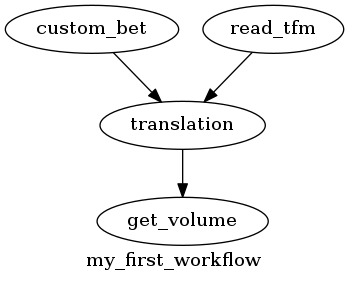

In [7]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="workflow_graph.dot.png")

This representation makes the dependency structure of the workflow obvious. (By the way, the names of the nodes in this graph are the names we gave our Node objects above, so pick something meaningful for those!)

Certain graph types also allow you to further inspect the individual connections between the nodes. For example:

170327-19:24:12,4 workflow INFO:
	 Generated workflow graph: /home/jovyan/work/graph_detailed.dot.png (graph2use=flat, simple_form=True).


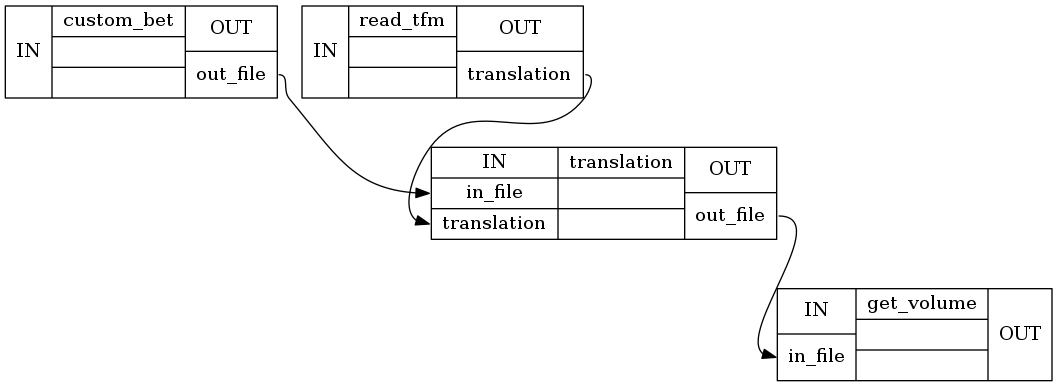

In [8]:
wf.write_graph(graph2use='flat')
from IPython.display import Image
Image(filename="graph_detailed.dot.png")

For more information on graph visualization, see the [Graph Visualization](./basic_graph_visualization.ipynb) section.

But let's come back to our example. At this point, all we've done is define the workflow. We haven't executed any code yet. Much like Interface objects, the Workflow object has a ``run`` method that we can call so that it executes. Let's do that and then examine the results.

In [9]:
# Specify the base directory for the working directory
wf.base_dir = "working_dir"

# Specify the workflow inputs:
wf.inputs.read_tfm.in_file = os.path.abspath('files/transform.tfm') # Note that the workflow will change the
                                                                    # working directory to ./working_dir/
wf.inputs.custom_bet.in_file = '/data/ds000114/sub-01/anat/sub-01_T1w.nii.gz'
wf.inputs.get_volume.script_file= os.path.abspath('files/brainvolume.m')

# Execute the workflow
wf.run()

170327-19:24:18,199 workflow INFO:
	 Workflow my_first_workflow settings: ['check', 'execution', 'logging']
170327-19:24:18,212 workflow INFO:
	 Running serially.
170327-19:24:18,215 workflow INFO:
	 Executing node custom_bet in dir: /home/jovyan/work/working_dir/my_first_workflow/custom_bet
170327-19:24:18,238 workflow INFO:
170327-19:24:18,257 workflow INFO:
	 Executing node read_tfm in dir: /home/jovyan/work/working_dir/my_first_workflow/read_tfm
170327-19:24:18,278 workflow INFO:
170327-19:24:18,293 workflow INFO:
	 Executing node translation in dir: /home/jovyan/work/working_dir/my_first_workflow/translation
170327-19:24:18,313 workflow INFO:
170327-19:24:18,323 workflow INFO:
	 Executing node get_volume in dir: /home/jovyan/work/working_dir/my_first_workflow/get_volume
170327-19:24:18,349 workflow INFO:


The specification of ``base_dir`` is very important (and is why we needed to use absolute paths above), because otherwise all the outputs would be saved somewhere in the temporary files. Unlike interfaces, which by default spit out results to the local directry, the Workflow engine executes things off in its own directory hierarchy.

In [10]:
!cat working_dir/my_first_workflow/get_volume/volume.txt

3329279

Perfect!

Let's also have a closer look at the working directory:

In [11]:
!tree working_dir -I '*js|*json|*html|*pklz|_report'

working_dir
└── my_first_workflow
    ├── custom_bet
    │   ├── brain.nii.gz
    │   └── command.txt
    ├── get_volume
    │   └── volume.txt
    ├── read_tfm
    │   └── command.txt
    └── translation
        └── transformed.nii.gz

5 directories, 5 files


As you can see, the name of the working directory is the name we gave the workflow ``base_dir``. And the name of the folder within is the name of the workflow object ``my_first_workflow``. Each node of the workflow has its own subfolder in the ``my_first_workflow`` folder. And each of those subfolders contains the output of the node as well as some additional files.

## The #1 gotcha of nipype Workflows

The workflows are just DAGs (Directed Acyclic Graphs) that the runner ``Plugin`` takes in and uses to compose an ordered list of nodes for execution. As a matter of fact, running a workflow will return a graph object, as we find in the output of cell 8:

  ```
  Out[8]: <networkx.classes.digraph.DiGraph at 0x7f92284a3050>
  ```
  

The principal implication is that ``Workflow``s *don't have inputs and outputs*, you can just access them through the ``Node`` decoration.

In practical terms, this has one clear consequence: from the resulting object of the workflow execution you don't generally have access to the value of the outputs of the interfaces. This is particularly true for Plugins with asynchronous execution.

## The smoothing workflow

Let's create a more useful workflow: we'll need three nodes. We'll first smooth the input image with a gaussian kernel and FWHM=4mm, then find the brain mask using BET and finally apply the brain mask on the smoothed image.

In [56]:
# Import Node and Workflow object and FSL interface
from nipype import Node, Workflow
from nipype.interfaces import fsl

# For reasons that will later become clear, it's important to
# pass filenames to Nodes as absolute paths
from os.path import abspath
in_file = abspath("/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz")

# Smooth process
node_smooth = Node(fsl.IsotropicSmooth(in_file=in_file, fwhm=4), name="smooth")

# Skullstrip process
node_bet = Node(fsl.BET(in_file=in_file, frac=0.2, mask=True), name="skullstrip")

# Mask process
node_mask = Node(fsl.ApplyMask(), name="mask")

### Exercise

Please connect the nodes in a workflow, so that the resulting graph looks like:
![smoothflow](./smoothflow.png)

In [58]:
# Initiation of a workflow
wf = Workflow(name="smoothflow")
wf.base_dir = 'smoothflow_example'

# Connect nodes here
wf.connect(node_bet, "mask_file", node_mask, "mask_file")

# Now the more complicated method
wf.connect([(node_smooth, node_mask, [("out_file", "in_file")])])

Now we can check the workflow graph and run it

170327-19:57:11,431 workflow INFO:
	 Generated workflow graph: smoothflow_example/smoothflow/workflow_graph.dot.png (graph2use=hierarchical, simple_form=True).


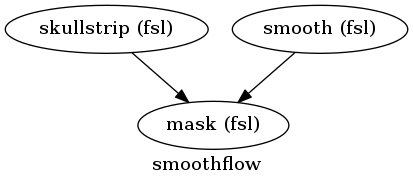

In [59]:
wf.write_graph("workflow_graph.dot")
from IPython.display import Image
Image(filename="smoothflow_example/smoothflow/workflow_graph.dot.png")

In [60]:
wf.run()

170327-19:57:11,457 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
170327-19:57:11,497 workflow INFO:
	 Running serially.
170327-19:57:11,505 workflow INFO:
	 Executing node smooth in dir: /home/jovyan/work/smoothflow_example/smoothflow/smooth
170327-19:57:11,543 workflow INFO:
170327-19:57:11,560 workflow INFO:
	 Executing node skullstrip in dir: /home/jovyan/work/smoothflow_example/smoothflow/skullstrip
170327-19:57:11,630 workflow INFO:
	 Running: bet /data/ds000114/sub-02/anat/sub-02_T1w.nii.gz /home/jovyan/work/smoothflow_example/smoothflow/skullstrip/sub-02_T1w_brain.nii.gz -f 0.20 -m
170327-19:57:15,768 workflow INFO:
	 Executing node mask in dir: /home/jovyan/work/smoothflow_example/smoothflow/mask
170327-19:57:15,808 workflow INFO:
	 Running: fslmaths /home/jovyan/work/smoothflow_example/smoothflow/smooth/sub-02_T1w_smooth.nii.gz -mas /home/jovyan/work/smoothflow_example/smoothflow/skullstrip/sub-02_T1w_brain_mask.nii.gz /home/jovyan/work/smoo

Results are cached:

In [61]:
wf.run()

170327-19:57:17,926 workflow INFO:
	 Workflow smoothflow settings: ['check', 'execution', 'logging']
170327-19:57:17,959 workflow INFO:
	 Running serially.
170327-19:57:17,966 workflow INFO:
	 Executing node smooth in dir: /home/jovyan/work/smoothflow_example/smoothflow/smooth
170327-19:57:18,5 workflow INFO:
170327-19:57:18,27 workflow INFO:
	 Executing node skullstrip in dir: /home/jovyan/work/smoothflow_example/smoothflow/skullstrip
170327-19:57:18,56 workflow INFO:
170327-19:57:18,74 workflow INFO:
	 Executing node mask in dir: /home/jovyan/work/smoothflow_example/smoothflow/mask
170327-19:57:18,99 workflow INFO:


... in the base_dir (``smoothflow_example``):

In [62]:
!tree smoothflow_example -I '*js|*json|*html|*pklz|_report'

smoothflow_example
└── smoothflow
    ├── mask
    │   ├── command.txt
    │   └── sub-02_T1w_smooth_masked.nii.gz
    ├── skullstrip
    │   ├── command.txt
    │   └── sub-02_T1w_brain_mask.nii.gz
    ├── smooth
    │   ├── command.txt
    │   └── sub-02_T1w_smooth.nii.gz
    ├── workflow_graph.dot
    └── workflow_graph.dot.png

4 directories, 8 files


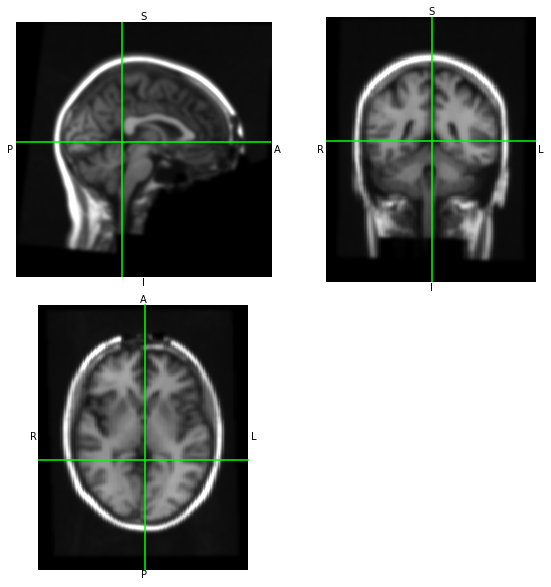

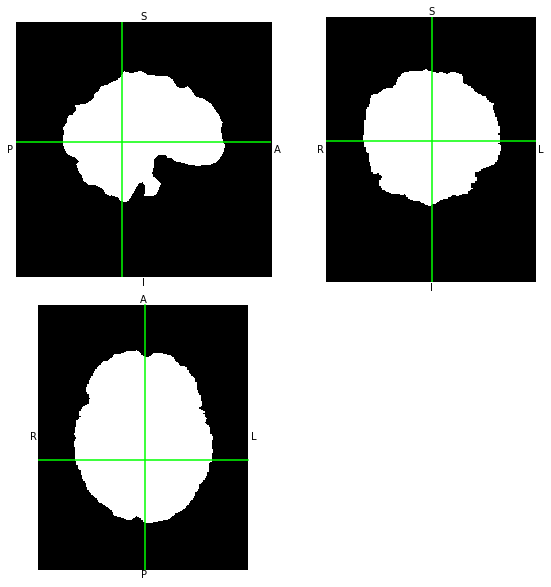

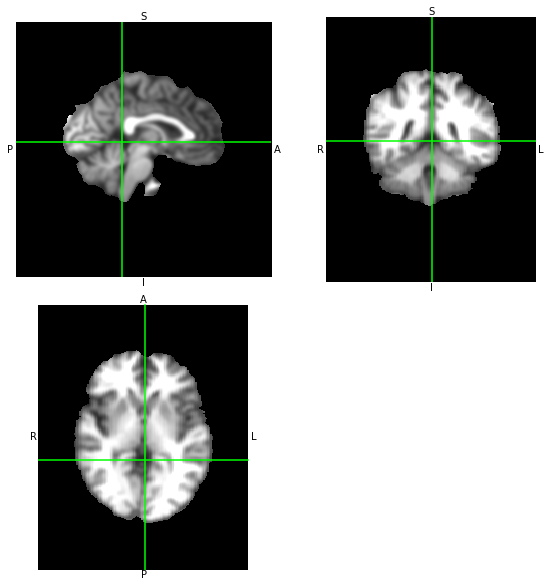

In [64]:
plot_nii('./smoothflow_example/smoothflow/smooth/sub-02_T1w_smooth.nii.gz')
plot_nii('./smoothflow_example/smoothflow/skullstrip/sub-02_T1w_brain_mask.nii.gz')
plot_nii('./smoothflow_example/smoothflow/mask/sub-02_T1w_smooth_masked.nii.gz')

# Pre-defined nipype workflows

170327-19:57:37,296 workflow INFO:
	 Generated workflow graph: denoise_workflow/Denoise/nlmeans_pipeline.dot.png (graph2use=hierarchical, simple_form=True).


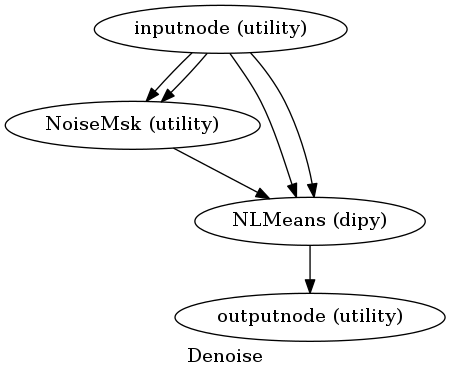

In [65]:
from os import path as op
from nipype.workflows.dmri.dipy.denoise import nlmeans_pipeline
denoise = nlmeans_pipeline()
denoise.base_dir = 'denoise_workflow'
denoise.write_graph("nlmeans_pipeline.dot")
Image(filename="denoise_workflow/Denoise/nlmeans_pipeline.dot.png")

In [66]:
denoise.inputs.inputnode.in_file = "/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz"
denoise.inputs.inputnode.in_mask = op.abspath('./smoothflow_example/smoothflow/skullstrip/sub-02_T1w_brain_mask.nii.gz')
denoise.run() 

170327-19:57:37,344 workflow INFO:
	 Workflow Denoise settings: ['check', 'execution', 'logging']
170327-19:57:37,390 workflow INFO:
	 Running serially.
170327-19:57:37,395 workflow INFO:
	 Executing node NoiseMsk in dir: /home/jovyan/work/denoise_workflow/Denoise/NoiseMsk
170327-19:58:36,221 workflow INFO:
	 Executing node NLMeans in dir: /home/jovyan/work/denoise_workflow/Denoise/NLMeans
170327-19:59:29,122 interface INFO:
	 Denoised image saved as /home/jovyan/work/denoise_workflow/Denoise/NLMeans/sub-02_T1w_denoise.nii.gz, estimated SNR=[5.4565535]


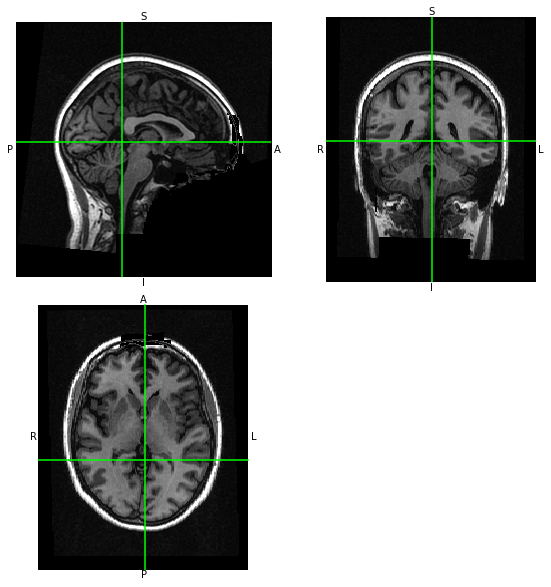

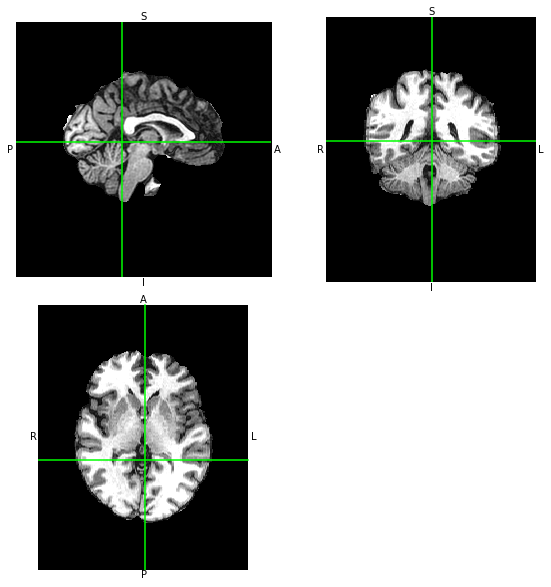

In [67]:
plot_nii("/data/ds000114/sub-02/anat/sub-02_T1w.nii.gz")
plot_nii("/home/jovyan/work/denoise_workflow/Denoise/NLMeans/sub-02_T1w_denoise.nii.gz")

## MRIQC Anatomical workflow
![some image](http://mriqc.readthedocs.io/en/latest//workflows-3.png)

When you start writing full-fledged analysis workflows, things can get quite complicated. Some aspects of neuroimaging analysis can be thought of as a coherent step at a level more abstract than the execution of a single command line binary. For instance, in the standard FEAT script in FSL, several calls are made in the process of using `susan` to perform nonlinear smoothing on an image. In Nipype, you can write **nested workflows**, where a sub-workflow can take the place of a Node in a given script.

Let's use the prepackaged `susan` workflow that ships with Nipype to replace our Gaussian filtering node and demonstrate how this works.

In [ ]:
from nipype.workflows.fmri.fsl import create_susan_smooth

Calling this function will return a pre-written `Workflow` object:

In [ ]:
susan = create_susan_smooth(separate_masks=False)

Let's display the graph to see what happens here.

In [ ]:
susan.write_graph("susan_workflow.dot")
from IPython.display import Image
Image(filename="susan_workflow.dot.png")

We see that the workflow has an `inputnode` and an `outputnode`. While not strictly necessary, this is standard practice for workflows (especially those that are intended to be used as nested workflows in the context of a longer analysis graph) and makes it more clear how to connect inputs and outputs from this workflow.

Let's take a look at what those inputs and outputs are. Like Nodes, Workflows have `inputs` and `outputs` attributes that take a second sub-attribute corresponding to the specific node we want to make connections to.

In [ ]:
print "Inputs:\n", susan.inputs.inputnode
print "Outputs:\n", susan.outputs.outputnode

Note that `inputnode` and `outputnode` are just conventions, and the Workflow object exposes connections to all of its component nodes:

In [ ]:
susan.inputs.median

Let's see how we would write a new workflow that uses this nested smoothing step.

The susan workflow actually expects to receive and output a list of files (it's intended to be executed on each of several runs of fMRI data). We'll cover exactly how that works in later tutorials, but for the moment we need to add an additional ``Function`` node to deal with the fact that ``susan`` is outputting a list. We can use a simple `lambda` function to do this:

In [ ]:
from nipype import Function
extract_func = lambda list_out: list_out[0]
list_extract = Node(Function(input_names=["list_out"],
                             output_names=["out_file"],
                             function=extract_func),
                    name="list_extract")

Now let's create a new workflow ``susanflow`` that contains the ``susan`` workflow as a sub-node. To be sure, let's also recreate the ``skullstrip`` and the ``mask`` node from the examples above.

In [ ]:
# Initiate workflow with name and base directory
wf2 = Workflow(name="susanflow", base_dir="working_dir")

# Create new skullstrip and mask nodes
skullstrip2 = Node(fsl.BET(in_file=in_file, mask=True), name="skullstrip")
mask2 = Node(fsl.ApplyMask(), name="mask")

# Connect the nodes to each other and to the susan workflow
wf2.connect([(skullstrip2, mask2, [("mask_file", "mask_file")]),
             (skullstrip2, susan, [("mask_file", "inputnode.mask_file")]),
             (susan, list_extract, [("outputnode.smoothed_files",
                                     "list_out")]),
             (list_extract, mask2, [("out_file", "in_file")])
             ])

# Specify the remaining input variables for the susan workflow
susan.inputs.inputnode.in_files = abspath(
    "/data/ds102/sub-02/anat/sub-02_T1w.nii.gz")
susan.inputs.inputnode.fwhm = 4

First, let's see what this new processing graph looks like.

In [ ]:
wf2.write_graph(dotfilename='./full_susanflow.dot', graph2use='colored')
from IPython.display import Image
Image(filename="full_susanflow.dot.png")

We can see how there is a nested smoothing workflow (blue) in the place of our previous `smooth` node. This provides a very detailed view, but what if you just wanted to give a higher-level summary of the processing steps? After all, that is the purpose of encapsulating smaller streams in a nested workflow. That, fortunately, is an option when writing out the graph:

In [ ]:
wf2.write_graph(dotfilename='./full_susanflow_toplevel.dot', graph2use='orig')
from IPython.display import Image
Image(filename="full_susanflow_toplevel.dot.png")

That's much more managable. Now let's execute the workflow

In [ ]:
wf2.run()

As a final step, let's look at the input and the output. It's exactly what we wanted.

In [ ]:
f = plt.figure(figsize=(12, 4))
for i, e in enumerate([["/data/ds102/sub-02/anat/sub-02_T1w.nii.gz", 'input'],
                       ["working_dir/susanflow/mask/sub-02_T1w_smooth_masked.nii.gz", 
                        'output']]):
    f.add_subplot(1, 2, i + 1)
    plot_slice(e[0])
    plt.title(e[1])

# So, why are workflows so great?

So far, we've seen that you can build up rather complex analysis workflows. But at the moment, it's not been made clear why this is worth the extra trouble from writing a simple procedural script. To demonstrate the first added benefit of the Nipype, let's just rerun the ``susanflow`` workflow from above and measure the execution times.

In [ ]:
%time
wf2.run()

That happened quickly! Workflows (actually this is handled by the Node code) are smart, and know if their inputs have changed from the last time they are run. If they have not, they don't recompute; they just turn around and pass out the resulting files from the previous run. This is done on a node-by-node basis, also.

Let's go back to the first workflow example. What happened if we just tweak one thing:

In [ ]:
wf.inputs.smooth.fwhm = 1
wf.run()

By changing an input value of the ``smooth`` node, this node will be re-executed. This triggers a cascade such that any file depending on the ``smooth`` node (in this case, the ``mask`` node, also recompute). However, the ``skullstrip`` node hasn't changed since the first time it ran, so it just coughed up its original files.

That's one of the main benefit of using Workflows: **efficient recomputing**. 

Another benefits of Workflows is parallel execution, which is covered under [Plugins and Distributed Computing](./basic_plugins.ipynb). With Nipype it is very easy to up a workflow to an extremely parallel cluster computing environment.

In this case, that just means that the `skullstrip` and `smooth` Nodes execute together, but when you scale up to Workflows with many subjects and many runs per subject, each can run together, such that (in the case of unlimited computing resources), you could process 50 subjects with 10 runs of functional data in essentially the time it would take to process a single run.

To emphasize the contribution of Nipype here, you can write and test your workflow on one subject computing on your local CPU, where it is easier to debug. Then, with the change of a single function parameter, you can scale your processing up to a 1000+ node SGE cluster.